# Core Workflow: Building Training Data
Construct and store training data using specified input stack, for any number of input sets (ie "image suffixes"). Presumes prior acquisition/preparation of both ground-truth and image files. Note that tiling must be consistent across ground-truth, imagery, and training data construction.
  
Date: 2018-09-12  
Author: Peter Kerins

### Import statements
(may be over-inclusive)

In [10]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf
import keras

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

# how do change this from manual?
sys.path.append('/home/Peter.Kerins/UrbanLandUse/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow


 [{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils', '/home/Peter.Kerins/UrbanLandUse/utils', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
place = 'sitapur'

data_root='/data/steven/data/'
data_path=data_root+place+'/'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=10  # Lx:15 S2:10

s1_bands=['vv','vh']; s1_suffix='VVVH'
s1_resolution = resolution

tile_resolution = resolution
tile_size = 256
tile_pad = 8

# ground truth source: labels, aue+osm, aue+osm2
label_suffix = 'aue+osm2'

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

sitapur Sitapur
>>> ogrinfo -al -so /data/steven/data/sitapur/Sitapur_studyArea.shp
INFO: Open of `/data/steven/data/sitapur/Sitapur_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Sitapur_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-18
Geometry: Polygon
Feature Count: 1
Extent: (452962.901712, 3030448.248706) - (484367.511519, 3076769.642552)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/steven/data/sitapur/Sitapur_studyAreaEPSG4326.shp
INFO: Open of `/data/steven/data

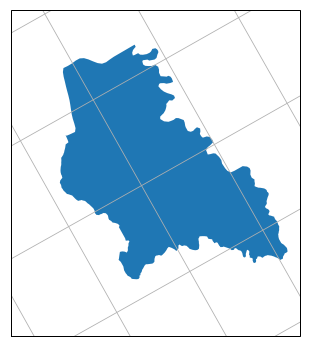

In [3]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 164
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[80.58452554952855, 27.493811245326476], [80.61206133747775, 27.493890725222546], [80.61197521086865, 27.518446163412445], [80.5844333100891, 27.518366600693632], [80.58452554952855, 27.493811245326476]]]}


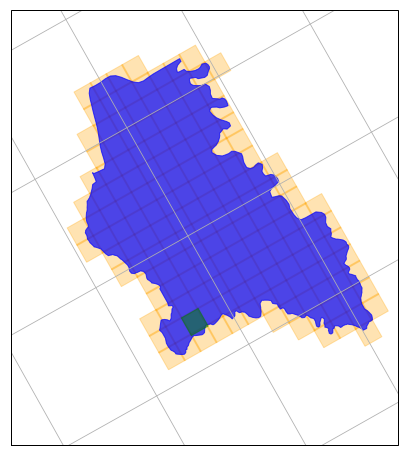

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Inspect ground truth files

In [5]:
label_stats = {}
for tile_id in range(len(tiles['features'])):
    tile = tiles['features'][tile_id]
    label_file = data_path+place+'_tile'+str(tile_id).zfill(3)+'_'+label_suffix+'.tif'
    label_stats[tile_id] = util_rasters.stats_byte_raster(label_file, category_label, show=False)

categories = [0,1,2,3,4,5,6]

stats = {}
for c in categories:
    stats[c] = 0

for tile_id in label_stats.keys():
    if label_stats[tile_id][255] != 73984: # (8 + 256 + 8)^2
        print tile_id, label_stats[tile_id]
    for c in categories:
        try:
            stats[c] = stats[c] + label_stats[tile_id][c]
        except:
            continue

print stats

/data/steven/data/sitapur/sitapur_tile000_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile001_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile002_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile003_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile004_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile005_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile006_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile007_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile008_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile009_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile010_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile011_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile012_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile

255 73984 No Label
/data/steven/data/sitapur/sitapur_tile101_aue+osm2.tif
0 756 Open Space
1 162 Non-Residential
6 82 Roads
255 72984 No Label
/data/steven/data/sitapur/sitapur_tile102_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile103_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile104_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile105_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile106_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile107_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile108_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile109_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile110_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile111_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile112_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile113_a

### Set training data construction parameters

In [6]:
window = 7    # width of square window

categories = [0,1,4,6]

bands_vir=bands[:-1]
bands_sar=s1_bands
bands_ndvi=None
bands_ndbi=None
bands_osm=None

haze_removal = False

image_suffix_list = ['A']#['J','K','L','M','N'] #['A','B','C','D','E','F','G','H','I']#


### Execute preparatory functions

In [7]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir+sar 8


### Build training data
Drawing on specified imagery to construct input stack according to parameters. Use input stack in combination with label file data to prepare and store training samples tile by tile. Combine per-tile training samples into single X and Y arrays. Split these combined arrays into training and validation sets, using a consistent permutation to preserve validation set integrity.

In [8]:
for image_suffix in image_suffix_list:
    print 'Constructing dataset tiles for ' + place.title() + ' image ' + image_suffix + ' using ground-truth \'' + label_suffix + '\' and input stack \'' + stack_label + '\''
    print ''
    util_workflow.construct_dataset_tiles(data_path, place, tiles, label_stats, image_suffix,
        window, stack_label, feature_count,
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,
        haze_removal=False,
        label_suffix=label_suffix, categories=categories, 
        category_label=category_label )
    
    print 'Combine dataset tiles into complete data arrays'
    X_data, Y_data = util_workflow.combine_dataset_tiles(data_path, place, tiles, label_suffix, image_suffix, stack_label, window)
    
    print 'Write complete datasets to file'
    util_workflow.split_dataset(data_path, place, label_suffix, stack_label, image_suffix, window)
    print ''

Constructing dataset tiles for Sitapur image A using ground-truth 'aue+osm2' and input stack 'vir+sar'

Feature count: 8
Stack label:  vir+sar
tile 53 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1184 - 0.4027 )
vir band 1 into imn band 1 ( 0.0955 - 0.4129 )
vir band 2 into imn band 2 ( 0.0659 - 0.4945 )
vir band 3 into imn band 3 ( 0.0788 - 0.8389 )
vir band 4 into imn band 4 ( 0.0551 - 0.6215 )
vir band 5 into imn band 5 ( 0.0319 - 0.5977 )
tile 53 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 272, 272) 8
tile 53 load labels
/data/steven/data/sitapur/sitapur_tile053_aue+osm2.tif
y.shape (9, 272, 272)
0 3204 Open Space
1 1489 Non-Residential
2 615 Residential Atomistic
3 1842 Residential Informal Subdivision
4 2457 Residential Formal Subdivision
5 0 Residential Housing Project
6 971 Roads
7 73984 Study Ar

tile 83 done

tile 84 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1216 - 0.2355 )
vir band 1 into imn band 1 ( 0.0951 - 0.2523 )
vir band 2 into imn band 2 ( 0.0693 - 0.3329 )
vir band 3 into imn band 3 ( 0.0815 - 0.4249 )
vir band 4 into imn band 4 ( 0.0687 - 0.4127 )
vir band 5 into imn band 5 ( 0.0392 - 0.3727 )
tile 84 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 272, 272) 8
tile 84 load labels
/data/steven/data/sitapur/sitapur_tile084_aue+osm2.tif
y.shape (9, 272, 272)
0 3438 Open Space
1 654 Non-Residential
2 894 Residential Atomistic
3 1627 Residential Informal Subdivision
4 2539 Residential Formal Subdivision
5 18 Residential Housing Project
6 749 Roads
7 73984 Study Area
8 7380 Labeled Study Area
tile 84 collect data,label samples
n_samples, sum {0: 3438, 1: 654, 4: 2539, 6: 749} 7380
X,Y shapes

NameError: name 'data_file' is not defined

## Single-line version
Executes the full workflow of this notebook with only a single function, using as parameters the initial key variables and the training data construction-specific variables. This function allows for the construction of training data for any imagery from any cities (presuming the existence of ground-truth and image files).

In [17]:
reload(util_workflow)

place_images = {}
place_images['sitapur'] = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N']
#place_images['belgaum'] = ['A','B','C','D','E','F','G']
#place_images['vijayawada'] = ['A','B','C','D','E','F']
#place_images['pune'] = ['A','B','C','D','E','F','G','H','I','J','K','L']
#place_images['hyderabad'] = ['A','B','C','D','E','F','G','H','I']

util_workflow.create_training_data(data_root, place_images, tile_resolution, tile_size, tile_pad, window, 
        bands_vir=bands_vir, bands_sar=bands_sar, bands_ndvi=None, bands_ndbi=None, bands_osm=None, haze_removal=haze_removal,
        label_suffix=label_suffix, categories=categories, category_label=category_label)

simple polygon
/data/steven/data/sitapur/sitapur_tile000_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile001_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile002_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile003_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile004_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile005_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile006_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile007_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile008_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile009_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile010_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile011_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile012_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitap

255 73984 No Label
/data/steven/data/sitapur/sitapur_tile098_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile099_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile100_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile101_aue+osm2.tif
0 756 Open Space
1 162 Non-Residential
6 82 Roads
255 72984 No Label
/data/steven/data/sitapur/sitapur_tile102_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile103_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile104_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile105_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile106_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile107_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile108_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile109_aue+osm2.tif
255 73984 No Label
/data/steven/data/sitapur/sitapur_tile110_a

tile 66 done

tile 67 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1187 - 0.2095 )
vir band 1 into imn band 1 ( 0.092 - 0.2284 )
vir band 2 into imn band 2 ( 0.068 - 0.2796 )
vir band 3 into imn band 3 ( 0.0619 - 0.3672 )
vir band 4 into imn band 4 ( 0.0342 - 0.448 )
vir band 5 into imn band 5 ( 0.0249 - 0.4118 )
tile 67 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 272, 272) 8
tile 67 load labels
/data/steven/data/sitapur/sitapur_tile067_aue+osm2.tif
y.shape (9, 272, 272)
0 2369 Open Space
1 1714 Non-Residential
2 177 Residential Atomistic
3 1262 Residential Informal Subdivision
4 1858 Residential Formal Subdivision
5 2 Residential Housing Project
6 1364 Roads
7 73984 Study Area
8 7305 Labeled Study Area
tile 67 collect data,label samples
n_samples, sum {0: 2369, 1: 1714, 4: 1858, 6: 1364} 7305
X,Y shapes


Constructing dataset tiles for Sitapur image B using ground-truth 'aue+osm2' and input stack 'vir+sar'

Feature count: 8
Stack label:  vir+sar
tile 53 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0785 - 0.423 )
vir band 1 into imn band 1 ( 0.0726 - 0.4719 )
vir band 2 into imn band 2 ( 0.0347 - 0.6418 )
vir band 3 into imn band 3 ( 0.063 - 0.6471 )
vir band 4 into imn band 4 ( 0.0481 - 0.4831 )
vir band 5 into imn band 5 ( 0.0327 - 0.5265 )
tile 53 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 272, 272) 8
tile 53 load labels
/data/steven/data/sitapur/sitapur_tile053_aue+osm2.tif
y.shape (9, 272, 272)
0 3204 Open Space
1 1489 Non-Residential
2 615 Residential Atomistic
3 1842 Residential Informal Subdivision
4 2457 Residential Formal Subdivision
5 0 Residential Housing Project
6 971 Roads
7 73984 Study Are

4 2685 (468, 392) (468,)
6 6 249
6 2934 (249, 392) (249,)
(2934, 392) (2934,) float32
/data/steven/data/sitapur/sitapur_tile083_aue+osm2_vir+sar_7w_B.pkl
tile 83 done

tile 84 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0894 - 0.3012 )
vir band 1 into imn band 1 ( 0.0718 - 0.3224 )
vir band 2 into imn band 2 ( 0.045 - 0.4528 )
vir band 3 into imn band 3 ( 0.0691 - 0.5297 )
vir band 4 into imn band 4 ( 0.065 - 0.4563 )
vir band 5 into imn band 5 ( 0.0381 - 0.4714 )
tile 84 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 272, 272) 8
tile 84 load labels
/data/steven/data/sitapur/sitapur_tile084_aue+osm2.tif
y.shape (9, 272, 272)
0 3438 Open Space
1 654 Non-Residential
2 894 Residential Atomistic
3 1627 Residential Informal Subdivision
4 2539 Residential Formal Subdivision
5 18 Residential Housing Project
6 749

tile 67 done

tile 68 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1133 - 0.2951 )
vir band 1 into imn band 1 ( 0.0972 - 0.3838 )
vir band 2 into imn band 2 ( 0.0795 - 0.4548 )
vir band 3 into imn band 3 ( 0.0914 - 0.4442 )
vir band 4 into imn band 4 ( 0.0613 - 0.5843 )
vir band 5 into imn band 5 ( 0.042 - 1.0 )
tile 68 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 272, 272) 8
tile 68 load labels
/data/steven/data/sitapur/sitapur_tile068_aue+osm2.tif
y.shape (9, 272, 272)
0 5694 Open Space
1 2284 Non-Residential
2 2126 Residential Atomistic
3 5289 Residential Informal Subdivision
4 7458 Residential Formal Subdivision
5 0 Residential Housing Project
6 1803 Roads
7 73984 Study Area
8 17239 Labeled Study Area
tile 68 collect data,label samples
n_samples, sum {0: 5694, 1: 2284, 4: 7458, 6: 1803} 17239
X,Y shap

tile 53 done

tile 54 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1286 - 0.2117 )
vir band 1 into imn band 1 ( 0.1227 - 0.2134 )
vir band 2 into imn band 2 ( 0.1036 - 0.2498 )
vir band 3 into imn band 3 ( 0.1401 - 0.3751 )
vir band 4 into imn band 4 ( 0.119 - 0.3777 )
vir band 5 into imn band 5 ( 0.0735 - 0.2827 )
tile 54 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 272, 272) 8
tile 54 load labels
/data/steven/data/sitapur/sitapur_tile054_aue+osm2.tif
y.shape (9, 272, 272)
0 462 Open Space
1 17 Non-Residential
2 3 Residential Atomistic
3 0 Residential Informal Subdivision
4 3 Residential Formal Subdivision
5 0 Residential Housing Project
6 22 Roads
7 73984 Study Area
8 504 Labeled Study Area
tile 54 collect data,label samples
n_samples, sum {0: 462, 1: 17, 4: 3, 6: 22} 504
X,Y shapes (504, 392) (504,)
0 

tile 84 done

tile 101 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1235 - 0.3604 )
vir band 1 into imn band 1 ( 0.1169 - 0.3976 )
vir band 2 into imn band 2 ( 0.0955 - 0.4563 )
vir band 3 into imn band 3 ( 0.1233 - 0.4936 )
vir band 4 into imn band 4 ( 0.1178 - 0.5718 )
vir band 5 into imn band 5 ( 0.0737 - 0.5767 )
tile 101 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 272, 272) 8
tile 101 load labels
/data/steven/data/sitapur/sitapur_tile101_aue+osm2.tif
y.shape (9, 272, 272)
0 756 Open Space
1 162 Non-Residential
2 0 Residential Atomistic
3 0 Residential Informal Subdivision
4 0 Residential Formal Subdivision
5 0 Residential Housing Project
6 82 Roads
7 73984 Study Area
8 1000 Labeled Study Area
tile 101 collect data,label samples
n_samples, sum {0: 756, 1: 162, 4: 0, 6: 82} 1000
X,Y shapes (1000, 392)

tile 68 done

tile 69 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1335 - 0.2045 )
vir band 1 into imn band 1 ( 0.1234 - 0.2339 )
vir band 2 into imn band 2 ( 0.1059 - 0.2797 )
vir band 3 into imn band 3 ( 0.1278 - 0.3632 )
vir band 4 into imn band 4 ( 0.0997 - 0.421 )
vir band 5 into imn band 5 ( 0.0669 - 0.3507 )
tile 69 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 272, 272) 8
tile 69 load labels
/data/steven/data/sitapur/sitapur_tile069_aue+osm2.tif
y.shape (9, 272, 272)
0 644 Open Space
1 27 Non-Residential
2 31 Residential Atomistic
3 34 Residential Informal Subdivision
4 65 Residential Formal Subdivision
5 0 Residential Housing Project
6 29 Roads
7 73984 Study Area
8 765 Labeled Study Area
tile 69 collect data,label samples
n_samples, sum {0: 644, 1: 27, 4: 65, 6: 29} 765
X,Y shapes (765, 392) (765,

tile 66 done

tile 67 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1274 - 0.2808 )
vir band 1 into imn band 1 ( 0.1158 - 0.2848 )
vir band 2 into imn band 2 ( 0.0986 - 0.3131 )
vir band 3 into imn band 3 ( 0.1188 - 0.4185 )
vir band 4 into imn band 4 ( 0.1042 - 0.4516 )
vir band 5 into imn band 5 ( 0.0711 - 0.3886 )
tile 67 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 272, 272) 8
tile 67 load labels
/data/steven/data/sitapur/sitapur_tile067_aue+osm2.tif
y.shape (9, 272, 272)
0 2369 Open Space
1 1714 Non-Residential
2 177 Residential Atomistic
3 1262 Residential Informal Subdivision
4 1858 Residential Formal Subdivision
5 2 Residential Housing Project
6 1364 Roads
7 73984 Study Area
8 7305 Labeled Study Area
tile 67 collect data,label samples
n_samples, sum {0: 2369, 1: 1714, 4: 1858, 6: 1364} 7305
X,Y sha


Constructing dataset tiles for Sitapur image G using ground-truth 'aue+osm2' and input stack 'vir+sar'

Feature count: 8
Stack label:  vir+sar
tile 53 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1358 - 0.2379 )
vir band 1 into imn band 1 ( 0.1166 - 0.2431 )
vir band 2 into imn band 2 ( 0.0905 - 0.2749 )
vir band 3 into imn band 3 ( 0.1253 - 0.3589 )
vir band 4 into imn band 4 ( 0.067 - 0.3935 )
vir band 5 into imn band 5 ( 0.0386 - 0.3484 )
tile 53 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.019607844 - 1.0 )
sar band 1 into imn band 7 ( 0.023529412 - 1.0 )
imn (8, 272, 272) 8
tile 53 load labels
/data/steven/data/sitapur/sitapur_tile053_aue+osm2.tif
y.shape (9, 272, 272)
0 3204 Open Space
1 1489 Non-Residential
2 615 Residential Atomistic
3 1842 Residential Informal Subdivision
4 2457 Residential Formal Subdivision
5 0 Residential Housing Project
6 971 Roads
7 73984 Study Ar

tile 83 done

tile 84 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1378 - 0.2078 )
vir band 1 into imn band 1 ( 0.1177 - 0.2213 )
vir band 2 into imn band 2 ( 0.0954 - 0.2583 )
vir band 3 into imn band 3 ( 0.1211 - 0.3857 )
vir band 4 into imn band 4 ( 0.0749 - 0.3697 )
vir band 5 into imn band 5 ( 0.0471 - 0.3237 )
tile 84 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.02745098 - 1.0 )
imn (8, 272, 272) 8
tile 84 load labels
/data/steven/data/sitapur/sitapur_tile084_aue+osm2.tif
y.shape (9, 272, 272)
0 3438 Open Space
1 654 Non-Residential
2 894 Residential Atomistic
3 1627 Residential Informal Subdivision
4 2539 Residential Formal Subdivision
5 18 Residential Housing Project
6 749 Roads
7 73984 Study Area
8 7380 Labeled Study Area
tile 84 collect data,label samples
n_samples, sum {0: 3438, 1: 654, 4: 2539, 6: 749} 7380
X,Y shapes 

tile 67 done

tile 68 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1563 - 0.2338 )
vir band 1 into imn band 1 ( 0.1293 - 0.2144 )
vir band 2 into imn band 2 ( 0.1052 - 0.2496 )
vir band 3 into imn band 3 ( 0.1091 - 0.3343 )
vir band 4 into imn band 4 ( 0.0462 - 0.4032 )
vir band 5 into imn band 5 ( 0.0278 - 0.3693 )
tile 68 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.023529412 - 1.0 )
imn (8, 272, 272) 8
tile 68 load labels
/data/steven/data/sitapur/sitapur_tile068_aue+osm2.tif
y.shape (9, 272, 272)
0 5694 Open Space
1 2284 Non-Residential
2 2126 Residential Atomistic
3 5289 Residential Informal Subdivision
4 7458 Residential Formal Subdivision
5 0 Residential Housing Project
6 1803 Roads
7 73984 Study Area
8 17239 Labeled Study Area
tile 68 collect data,label samples
n_samples, sum {0: 5694, 1: 2284, 4: 7458, 6: 1803} 17239
X,Y 

tile 53 done

tile 54 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.109 - 0.3527 )
vir band 1 into imn band 1 ( 0.0849 - 0.3841 )
vir band 2 into imn band 2 ( 0.0605 - 0.5083 )
vir band 3 into imn band 3 ( 0.0767 - 0.5057 )
vir band 4 into imn band 4 ( 0.0303 - 0.8508 )
vir band 5 into imn band 5 ( 0.0209 - 0.9592 )
tile 54 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 272, 272) 8
tile 54 load labels
/data/steven/data/sitapur/sitapur_tile054_aue+osm2.tif
y.shape (9, 272, 272)
0 462 Open Space
1 17 Non-Residential
2 3 Residential Atomistic
3 0 Residential Informal Subdivision
4 3 Residential Formal Subdivision
5 0 Residential Housing Project
6 22 Roads
7 73984 Study Area
8 504 Labeled Study Area
tile 54 collect data,label samples
n_samples, sum {0: 462, 1: 17, 4: 3, 6: 22} 504
X,Y shapes (504, 392) (504,)
0 

tile 84 done

tile 101 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1094 - 0.2685 )
vir band 1 into imn band 1 ( 0.0868 - 0.2709 )
vir band 2 into imn band 2 ( 0.0594 - 0.2995 )
vir band 3 into imn band 3 ( 0.0858 - 0.3834 )
vir band 4 into imn band 4 ( 0.0397 - 0.3871 )
vir band 5 into imn band 5 ( 0.0254 - 0.3912 )
tile 101 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.023529412 - 1.0 )
imn (8, 272, 272) 8
tile 101 load labels
/data/steven/data/sitapur/sitapur_tile101_aue+osm2.tif
y.shape (9, 272, 272)
0 756 Open Space
1 162 Non-Residential
2 0 Residential Atomistic
3 0 Residential Informal Subdivision
4 0 Residential Formal Subdivision
5 0 Residential Housing Project
6 82 Roads
7 73984 Study Area
8 1000 Labeled Study Area
tile 101 collect data,label samples
n_samples, sum {0: 756, 1: 162, 4: 0, 6: 82} 1000
X,Y shapes (1000, 392)

tile 68 done

tile 69 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1092 - 0.2075 )
vir band 1 into imn band 1 ( 0.0931 - 0.2345 )
vir band 2 into imn band 2 ( 0.0627 - 0.2383 )
vir band 3 into imn band 3 ( 0.0915 - 0.4178 )
vir band 4 into imn band 4 ( 0.041 - 0.4001 )
vir band 5 into imn band 5 ( 0.0222 - 0.3283 )
tile 69 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.023529412 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 0.0 )
imn (8, 272, 272) 8
tile 69 load labels
/data/steven/data/sitapur/sitapur_tile069_aue+osm2.tif
y.shape (9, 272, 272)
0 644 Open Space
1 27 Non-Residential
2 31 Residential Atomistic
3 34 Residential Informal Subdivision
4 65 Residential Formal Subdivision
5 0 Residential Housing Project
6 29 Roads
7 73984 Study Area
8 765 Labeled Study Area
tile 69 collect data,label samples
n_samples, sum {0: 644, 1: 27, 4: 65, 6: 29} 765
X,Y shapes (765, 392) (765,)
0 0 64

tile 66 done

tile 67 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1271 - 0.2238 )
vir band 1 into imn band 1 ( 0.099 - 0.243 )
vir band 2 into imn band 2 ( 0.074 - 0.3004 )
vir band 3 into imn band 3 ( 0.0708 - 0.3737 )
vir band 4 into imn band 4 ( 0.0362 - 0.4697 )
vir band 5 into imn band 5 ( 0.0234 - 0.4281 )
tile 67 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 0.0 )
imn (8, 272, 272) 8
tile 67 load labels
/data/steven/data/sitapur/sitapur_tile067_aue+osm2.tif
y.shape (9, 272, 272)
0 2369 Open Space
1 1714 Non-Residential
2 177 Residential Atomistic
3 1262 Residential Informal Subdivision
4 1858 Residential Formal Subdivision
5 2 Residential Housing Project
6 1364 Roads
7 73984 Study Area
8 7305 Labeled Study Area
tile 67 collect data,label samples
n_samples, sum {0: 2369, 1: 1714, 4: 1858, 6: 1364} 7305
X,Y shapes (7305, 

tile 53 done

tile 54 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1457 - 0.2253 )
vir band 1 into imn band 1 ( 0.1207 - 0.2142 )
vir band 2 into imn band 2 ( 0.0924 - 0.2148 )
vir band 3 into imn band 3 ( 0.1097 - 0.3563 )
vir band 4 into imn band 4 ( 0.0622 - 0.351 )
vir band 5 into imn band 5 ( 0.0371 - 0.3198 )
tile 54 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.02745098 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 0.0 )
imn (8, 272, 272) 8
tile 54 load labels
/data/steven/data/sitapur/sitapur_tile054_aue+osm2.tif
y.shape (9, 272, 272)
0 462 Open Space
1 17 Non-Residential
2 3 Residential Atomistic
3 0 Residential Informal Subdivision
4 3 Residential Formal Subdivision
5 0 Residential Housing Project
6 22 Roads
7 73984 Study Area
8 504 Labeled Study Area
tile 54 collect data,label samples
n_samples, sum {0: 462, 1: 17, 4: 3, 6: 22} 504
X,Y shapes (504, 392) (504,)
0 0 462
0 4

tile 84 done

tile 101 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1507 - 0.2455 )
vir band 1 into imn band 1 ( 0.1251 - 0.2328 )
vir band 2 into imn band 2 ( 0.0955 - 0.2541 )
vir band 3 into imn band 3 ( 0.123 - 0.3374 )
vir band 4 into imn band 4 ( 0.0542 - 0.3659 )
vir band 5 into imn band 5 ( 0.022 - 0.4057 )
tile 101 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.023529412 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 0.0 )
imn (8, 272, 272) 8
tile 101 load labels
/data/steven/data/sitapur/sitapur_tile101_aue+osm2.tif
y.shape (9, 272, 272)
0 756 Open Space
1 162 Non-Residential
2 0 Residential Atomistic
3 0 Residential Informal Subdivision
4 0 Residential Formal Subdivision
5 0 Residential Housing Project
6 82 Roads
7 73984 Study Area
8 1000 Labeled Study Area
tile 101 collect data,label samples
n_samples, sum {0: 756, 1: 162, 4: 0, 6: 82} 1000
X,Y shapes (1000, 392) (1000,)
0

tile 68 done

tile 69 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1072 - 0.1898 )
vir band 1 into imn band 1 ( 0.0874 - 0.2072 )
vir band 2 into imn band 2 ( 0.0646 - 0.2564 )
vir band 3 into imn band 3 ( 0.0813 - 0.3934 )
vir band 4 into imn band 4 ( 0.0438 - 0.3995 )
vir band 5 into imn band 5 ( 0.0263 - 0.3501 )
tile 69 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 0.0 )
imn (8, 272, 272) 8
tile 69 load labels
/data/steven/data/sitapur/sitapur_tile069_aue+osm2.tif
y.shape (9, 272, 272)
0 644 Open Space
1 27 Non-Residential
2 31 Residential Atomistic
3 34 Residential Informal Subdivision
4 65 Residential Formal Subdivision
5 0 Residential Housing Project
6 29 Roads
7 73984 Study Area
8 765 Labeled Study Area
tile 69 collect data,label samples
n_samples, sum {0: 644, 1: 27, 4: 65, 6: 29} 765
X,Y shapes (765, 392) (765,)
0 0 6

tile 66 done

tile 67 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1037 - 0.2642 )
vir band 1 into imn band 1 ( 0.0862 - 0.2715 )
vir band 2 into imn band 2 ( 0.0662 - 0.3413 )
vir band 3 into imn band 3 ( 0.0761 - 0.4051 )
vir band 4 into imn band 4 ( 0.0565 - 0.4966 )
vir band 5 into imn band 5 ( 0.038 - 0.4481 )
tile 67 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 0.0 )
imn (8, 272, 272) 8
tile 67 load labels
/data/steven/data/sitapur/sitapur_tile067_aue+osm2.tif
y.shape (9, 272, 272)
0 2369 Open Space
1 1714 Non-Residential
2 177 Residential Atomistic
3 1262 Residential Informal Subdivision
4 1858 Residential Formal Subdivision
5 2 Residential Housing Project
6 1364 Roads
7 73984 Study Area
8 7305 Labeled Study Area
tile 67 collect data,label samples
n_samples, sum {0: 2369, 1: 1714, 4: 1858, 6: 1364} 7305
X,Y shapes (7305